#### <center>Plots for the article:
<center>Do Women Really Comply More?
Experimental Evidence from a Representative Sample</center>


In [1]:
# This file produces the plots for the simulation part of the paper

import numpy as np
import pandas as pd
import numba as nb

np.random.seed(777)

# Useful functions for calculations
@nb.njit
def expected_black_balls(draws):
    expected_values = np.zeros(len(draws))
    for i, k in enumerate(draws):
        expected_sum = 0.0
        for j in range(k):
            expected_sum += 5 / (100 - j)
        expected_values[i] = expected_sum
    return expected_values

def calculate_expected_black_balls(data_dict):
    results = {}
    for condition, rounds_data in data_dict.items():
        results[condition] = []
        for draws in rounds_data:
            expected_values = expected_black_balls(draws)  # Calculate expected black balls
            results[condition].append(expected_values)
    return results

@nb.njit
def expected_black_prob(draws):
    probs = np.zeros(len(draws))
    for i, k in enumerate(draws):
        no_black_prob = 1.0
        for j in range(k):
            no_black_prob *= (95 - j) / (100 - j)
        probs[i] = 1 - no_black_prob
    return probs

# Data is organized in a dictionary
def create_data_dict(df):
    conditions = ['Baseline', 'Recommendation', 'Rec.+peer info']
    rounds = np.arange(1, 11)
    data_dict = {condition: [] for condition in conditions}
    for condition in conditions:
        for raundo in rounds:
            draws = df.loc[(df['condition'] == condition) & (df['round'] == raundo), 'draws'].values
            data_dict[condition].append(draws)
    return data_dict

def calculate_expected_probs(data_dict):
    results = {}
    for condition, rounds_data in data_dict.items():
        results[condition] = []
        for draws in rounds_data:
            expected_probs = expected_black_prob(draws)  # Calculate expected probabilities
            results[condition].append(expected_probs)
    return results

dfra = pd.read_excel('./exp1.xls')

dfra_men = dfra[dfra['female'] == 'male']
dfra_women = dfra[dfra['female'] == 'female']

data_dict_men = create_data_dict(dfra_men)
data_dict_women = create_data_dict(dfra_women)

expected_probs_men = calculate_expected_probs(data_dict_men)
expected_probs_women = calculate_expected_probs(data_dict_women)

expected_black_balls_men = calculate_expected_black_balls(data_dict_men)
expected_black_balls_women = calculate_expected_black_balls(data_dict_women)

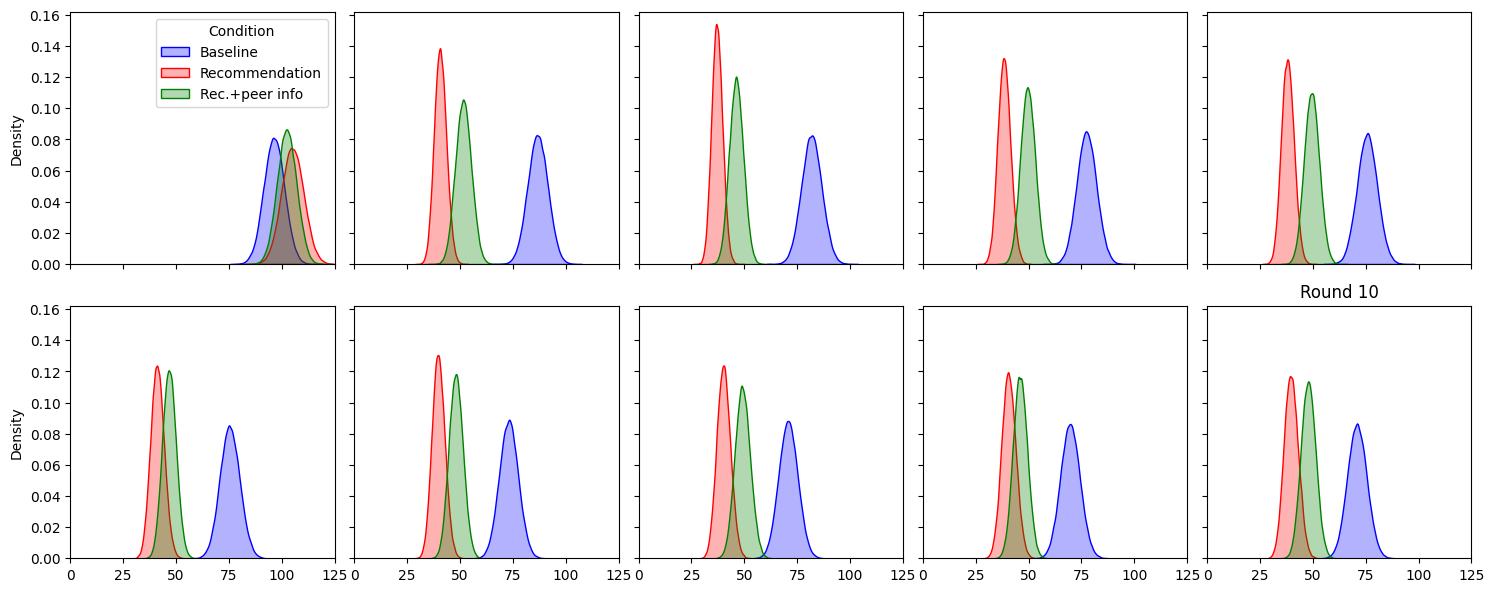

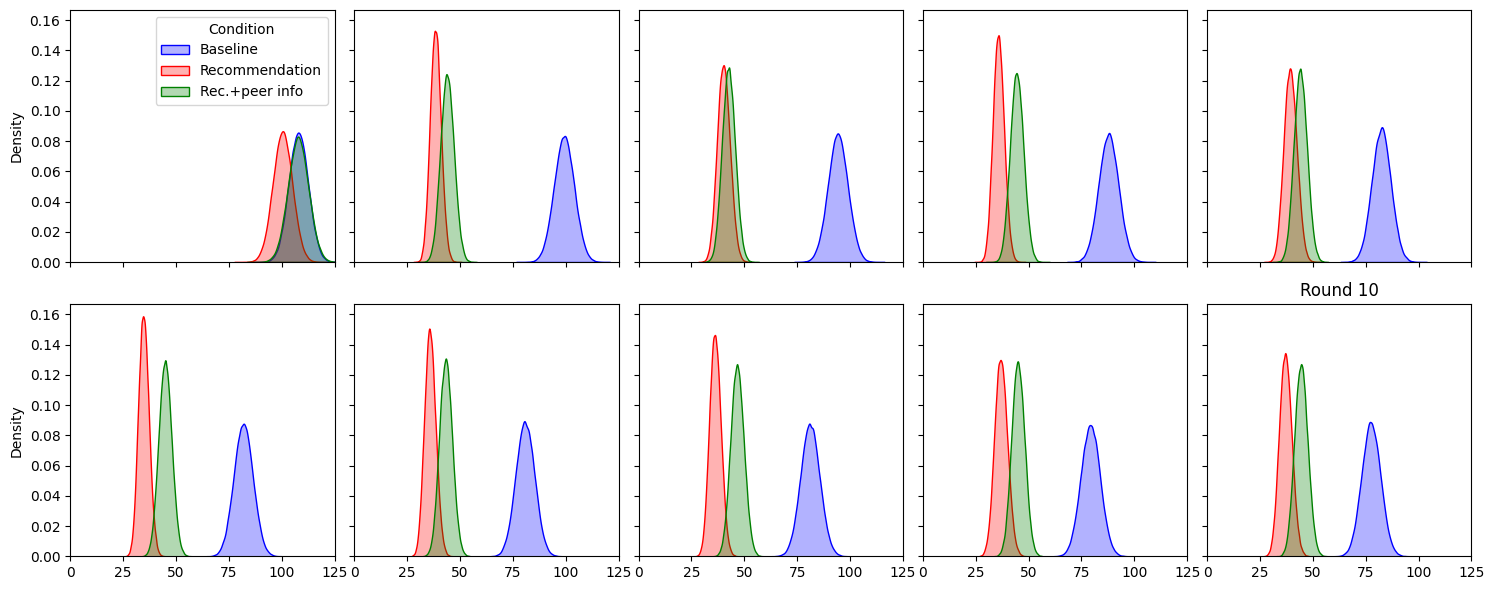

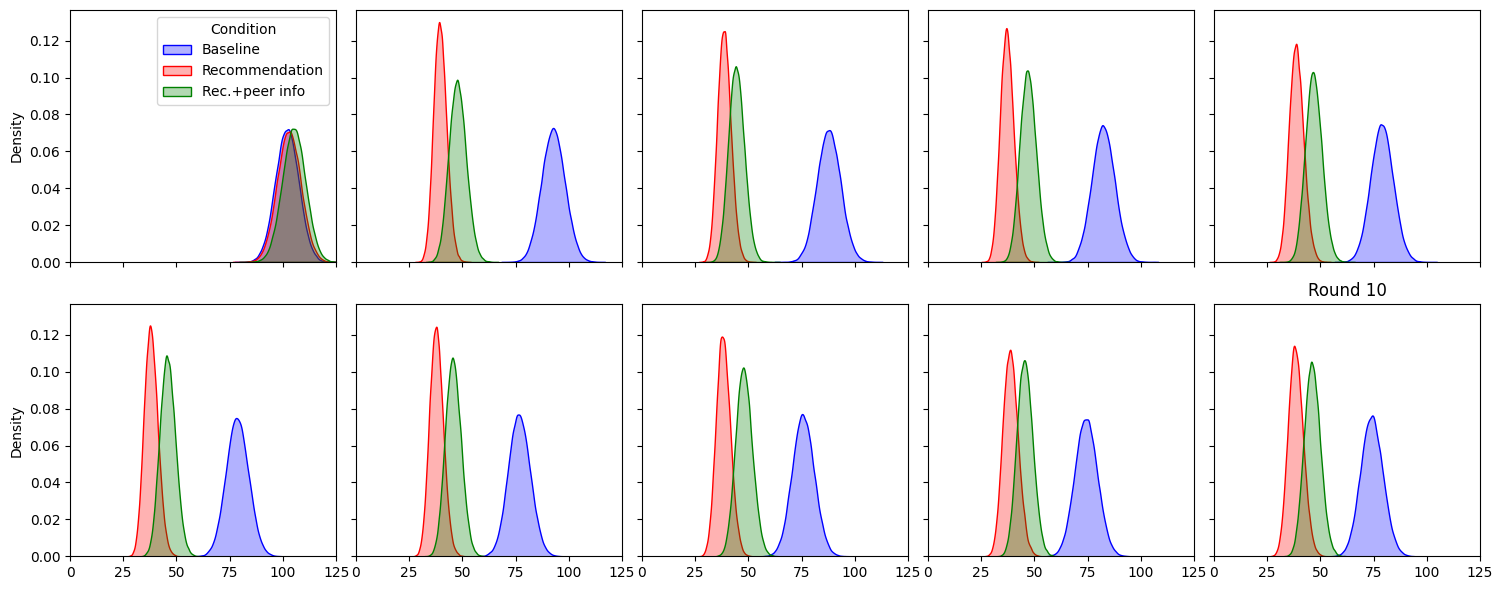

In [ ]:
# This cell calculates the expected black balls and produces the graphs for all 10 rounds

import seaborn as sns
import matplotlib.pyplot as plt

palette = {
    "Baseline": "#0000ff",
    "Recommendation": "#ff0000",
    "Rec.+peer info": "#008000"
}

@nb.njit
def simulate_black_ball_samples(expected_black_balls, n_samples=100000, sample_size=100):
    n_rounds = len(expected_black_balls)
    total_samples = np.zeros((n_rounds, n_samples), dtype=np.float64)
    for i in range(n_rounds):
        for j in range(n_samples):
            sample = np.random.choice(expected_black_balls[i], sample_size, replace=False)
            total_samples[i, j] = np.sum(sample)
    return total_samples

def simulate_by_condition_combined(data_dict_men, data_dict_women, n_samples=100000, sample_size=100):
    simulated_results = {}
    for condition in data_dict_men.keys():
        men_data = [np.array(round_data) for round_data in data_dict_men[condition]]
        women_data = [np.array(round_data) for round_data in data_dict_women[condition]]
        combined_data = [np.concatenate((round_m, round_w)) for round_m, round_w in zip(men_data, women_data)]
        
        simulated_results[condition] = simulate_black_ball_samples(combined_data, n_samples, sample_size)
    return simulated_results

def simulate_by_condition(data_dict, n_samples=100000, sample_size=100):
    simulated_results = {}
    for condition, rounds_data in data_dict.items():
        expected_black = [np.array(round_data) for round_data in rounds_data]
        simulated_results[condition] = simulate_black_ball_samples(expected_black, n_samples, sample_size)
    return simulated_results

simulated_men = simulate_by_condition(expected_black_balls_men)
simulated_women = simulate_by_condition(expected_black_balls_women)
simulated_combined = simulate_by_condition_combined(expected_black_balls_men, expected_black_balls_women)


def plot_kde_npy(data_dict, title, save_path):
    n_rounds = len(next(iter(data_dict.values())))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, (condition, samples) in enumerate(data_dict.items()):
        for round_idx in range(n_rounds):
            sns.kdeplot(
                samples[round_idx],
                ax=axes[round_idx],
                label=condition,
                fill=True,
                alpha=0.3,
                color=palette[condition]
            )
        axes[round_idx].set_title(f"Round {round_idx + 1}")
        axes[round_idx].set_xlim(0, 125)

    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles=handles, labels=labels, title="Condition")

    for ax in axes[1:]:
        if ax.legend_ is not None: # Legend only in 1st plot
            ax.legend_.remove()

    fig.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Uncomment to save the plots, double-check the path where it will be saved!
# plot_kde_npy(simulated_men, "Men KDE", "./simul_men_kde.png")
# plot_kde_npy(simulated_women, "Women KDE", "./simul_women_kde.png")
# plot_kde_npy(simulated_combined, "Combined KDE", "./simul_combined_kde.png")

In [ ]:
# This cell produces some summary information from the simulation results from above

#@nb.njit no numba here - not needed
def calculate_avg_sd_black_balls_for_round_2(simulated_data, round_idx=1):
    stats_black_balls = {}
    for condition, samples in simulated_data.items():
        round_2_data = samples[round_idx]  # Extract round 2 data
        mean = np.mean(round_2_data)
        sd = np.std(round_2_data)
        stats_black_balls[condition] = {"mean": mean, "sd": sd}
    return stats_black_balls

stats_black_balls_men = calculate_avg_sd_black_balls_for_round_2(simulated_men)
stats_black_balls_women = calculate_avg_sd_black_balls_for_round_2(simulated_women)
stats_black_balls_combined = calculate_avg_sd_black_balls_for_round_2(simulated_combined)

print("Average and Standard Deviation of Black Balls for Round 2:")
print("Men:")
for condition, stats in stats_black_balls_men.items():
    print(f"  {condition}: Mean = {stats['mean']:.2f}, SD = {stats['sd']:.2f}")

print("Women:")
for condition, stats in stats_black_balls_women.items():
    print(f"  {condition}: Mean = {stats['mean']:.2f}, SD = {stats['sd']:.2f}")

print("Combined:")
for condition, stats in stats_black_balls_combined.items():
    print(f"  {condition}: Mean = {stats['mean']:.2f}, SD = {stats['sd']:.2f}")


Average and Standard Deviation of Black Balls for Round 2:
Men:
  Baseline: Mean = 86.66, SD = 4.77
  Recommendation: Mean = 40.59, SD = 2.86
  Rec.+peer info: Mean = 51.52, SD = 3.75
Women:
  Baseline: Mean = 99.16, SD = 4.76
  Recommendation: Mean = 38.33, SD = 2.56
  Rec.+peer info: Mean = 43.88, SD = 3.18
Combined:
  Baseline: Mean = 92.63, SD = 5.49
  Recommendation: Mean = 39.48, SD = 3.05
  Rec.+peer info: Mean = 47.71, SD = 4.03


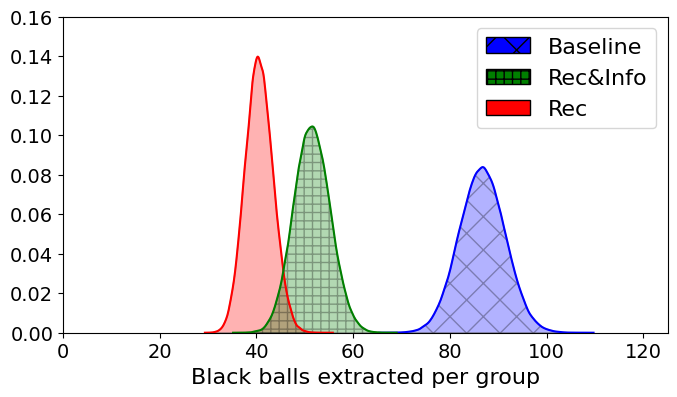

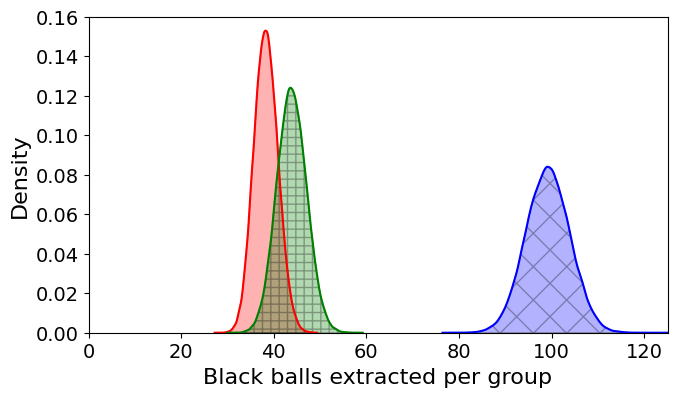

In [ ]:
# This cell calculates the expected black balls and produces the graphs for round 2 only

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numba as nb

np.random.seed(777)

@nb.njit
def simulate_black_ball_samples(expected_black_balls, n_samples=100000, sample_size=100):
    n_rounds = len(expected_black_balls)
    total_samples = np.zeros((n_rounds, n_samples), dtype=np.float64)
    for i in range(n_rounds):
        for j in range(n_samples):
            sample = np.random.choice(expected_black_balls[i], sample_size, replace=False)
            total_samples[i, j] = np.sum(sample)
    return total_samples

def simulate_by_condition(data_dict, n_samples=100000, sample_size=100):
    simulated_results = {}
    for condition, rounds_data in data_dict.items():
        expected_black = [np.array(round_data) for round_data in rounds_data]
        simulated_results[condition] = simulate_black_ball_samples(expected_black, n_samples, sample_size)
    return simulated_results

simulated_men = simulate_by_condition(expected_black_balls_men)
simulated_women = simulate_by_condition(expected_black_balls_women)

def prepare_dataframe(simulated_data, gender_label):
    dfs = []
    for condition, samples in simulated_data.items():
        df = pd.DataFrame(samples.T)
        df["condition"] = condition
        df["gender"] = gender_label
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.columns = [f"round_{idx+1}" if "condition" not in str(col) and "gender" not in str(col) else col for idx, col in enumerate(combined_df.columns)]
    return combined_df

df_men = prepare_dataframe(simulated_men, "men")
df_women = prepare_dataframe(simulated_women, "women")
df_combined = pd.concat([df_men, df_women], ignore_index=True)

df_combined_melted = pd.melt(
    df_combined,
    id_vars=["condition", "gender"],
    var_name="round",
    value_name="black"
)

df_combined_melted = df_combined_melted.explode("black").reset_index(drop=True)

palette = {
    "Baseline": "#0000ff",
    "Recommendation": "#ff0000",
    "Rec.+peer info": "#008000"
}
hatches = {  # TIL that they are called hatches
    "Baseline": "X",
    "Rec.+peer info": "++",
    "Recommendation": ""
}

def plot_kde_by_gender(df_gender, gender_label, save_path):
    g = sns.FacetGrid(
        df_gender,
        col="round",
        col_wrap=5,
        height=2,
        aspect=1.5,
        sharey=True,
        sharex=True,
        legend_out=False,
        hue="condition",
        palette=palette
    )

    for condition in df_gender["condition"].unique():
        g.map_dataframe(
            sns.kdeplot,
            "black",
            color=palette[condition],
            fill=False,
            alpha=1
        )
        g.map_dataframe(
            sns.kdeplot,
            "black",
            color=palette[condition],
            fill=True,
            alpha=0.3,
            label=condition,
            hatch=hatches[condition],
            edgecolor="black"
        )

    g.set_axis_labels("", "")
    g.set_titles(f"{gender_label.capitalize()} - {{col_name}}")
    g.add_legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

df_men_plot = df_combined_melted[df_combined_melted["gender"] == "men"]
df_women_plot = df_combined_melted[df_combined_melted["gender"] == "women"]

def plot_single_round_kde(df_gender, round_number, gender_label, save_path, add_legend=True):
    fig, ax = plt.subplots(figsize=(7, 4))

    df_round = df_gender[df_gender["round"] == f"round_{round_number}"]

    for condition in df_round["condition"].unique():
        condition_data = df_round[df_round["condition"] == condition]["black"].dropna().astype(float)
        kde = sns.kdeplot(
            condition_data,
            label=None,
            color=palette[condition],
            alpha=1,
            linestyle="-",
            ax=ax
        )
        x, y = kde.get_lines()[-1].get_data()
        ax.fill_between(
            x, y, alpha=0.3,
            color=palette[condition],
            hatch=hatches[condition],
            edgecolor="black"
        )

    handles = [
        mpatches.Patch(facecolor=palette[cond], edgecolor="black", hatch=hatches[cond], label=cond)
        for cond in hatches.keys()
    ]
    if add_legend:
        custom_labels = {
            "Baseline": "Baseline",
            "Recommendation": "Rec",
            "Rec.+peer info": "Rec&Info"
        }
        handles = [
            mpatches.Patch(facecolor=palette[cond], edgecolor="black", hatch=hatches[cond], label=custom_labels[cond])
            for cond in hatches.keys()]
        ax.legend(handles=handles, title=None, fontsize=16, title_fontsize=14, loc="upper right")
    ax.set_xlabel("Black balls extracted per group", fontsize=16)
    if add_legend:
        ax.set_ylabel(None)        
    else:
        ax.set_ylabel("Density", fontsize=16)
    ax.tick_params(axis="both", labelsize=14)

    ax.set_xlim(0, 125)
    ax.set_ylim(0, 0.16)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# We can choose the round here. Uncomment the line below to save the plots (see also 2 cells above!).
# plot_single_round_kde(df_men_plot, 2, "men", "./simul_men_round2_hatched.png", add_legend=True)
# plot_single_round_kde(df_women_plot, 2, "women", "./simul_women_round2_hatched.png", add_legend=False)

In [ ]:
# This cell calculates the statistical tests for expected black balls (Wilcoxon rank-sum test)

from scipy.stats import ranksums

exp_m_base = expected_black_balls_men["Baseline"][1:]
exp_m_info = expected_black_balls_men["Rec.+peer info"][1:]
exp_m_reco = expected_black_balls_men["Recommendation"][1:]

exp_f_base = expected_black_balls_women["Baseline"][1:]
exp_f_info = expected_black_balls_women["Rec.+peer info"][1:]
exp_f_reco = expected_black_balls_women["Recommendation"][1:]

for round in range(0, 9):

    print(round)

    base_stat, base_p_value = ranksums(exp_m_base[round], exp_f_base[round])
    info_stat, info_p_value = ranksums(exp_m_info[round], exp_f_info[round])
    reco_stat, reco_p_value = ranksums(exp_m_reco[round], exp_f_reco[round])


    print(base_stat, base_p_value)
    print(info_stat, info_p_value)
    print(reco_stat, reco_p_value)

exp_m_base_all = []

for round in exp_m_base:
    for draw in round:
        exp_m_base_all.append(draw)

exp_f_base_all = []

for round in exp_f_base:
    for draw in round:
        exp_f_base_all.append(draw)

exp_m_info_all = []

for round in exp_m_info:
    for draw in round:
        exp_m_info_all.append(draw)

exp_f_info_all = []

for round in exp_f_info:
    for draw in round:
        exp_f_info_all.append(draw)

exp_m_reco_all = []

for round in exp_m_reco:
    for draw in round:
        exp_m_reco_all.append(draw)

exp_f_reco_all = []

for round in exp_f_reco:
    for draw in round:
        exp_f_reco_all.append(draw)

0
-2.3495777052955558 0.018794720682496994
2.4394784227991955 0.014708481022871048
0.43335088088080714 0.6647598790920533
1
-2.4527414992646257 0.014177217884875963
1.318327446098436 0.1873940570154473
-0.8181449907620193 0.4132744014068648
2
-1.9910314934030542 0.04647742501142409
1.3573293851001742 0.17467657445608564
0.25254400997276766 0.8006206011597994
3
-1.4386443775686695 0.150251306144994
1.361662933878145 0.17330428402303377
-0.8769499244851469 0.3805138375645546
4
-1.6208905035140289 0.10504112387248005
0.36525625414326235 0.7149201299288526
1.2597920033714005 0.2077444052628038
5
-1.6527018175044914 0.09839156433273752
1.3669251002513954 0.1716487835585384
0.3777179975244873 0.70564009649867
6
-2.2526572533246143 0.02428076816897767
-0.38568584123941096 0.6997293501104864
0.6114737091707785 0.5408860183606203
7
-1.915219483425784 0.05546451877685533
-0.23246393801829665 0.8161776933581364
0.7744682972498208 0.4386539089229263
8
-1.4454823235666194 0.14832245456244056
0.0529

In [5]:
import numpy as np

for round in range(0, 9):
    print(f"Round {round + 1}:")
    
    # Calculate averages for males and females in each condition
    base_avg_m = np.mean(exp_m_base[round])
    base_avg_f = np.mean(exp_f_base[round])
    info_avg_m = np.mean(exp_m_info[round])
    info_avg_f = np.mean(exp_f_info[round])
    reco_avg_m = np.mean(exp_m_reco[round])
    reco_avg_f = np.mean(exp_f_reco[round])
    
    # Print averages
    print(f"  Baseline:    Male Avg: {base_avg_m:.2f}, Female Avg: {base_avg_f:.2f}")
    print(f"  Info:        Male Avg: {info_avg_m:.2f}, Female Avg: {info_avg_f:.2f}")
    print(f"  Recommendation: Male Avg: {reco_avg_m:.2f}, Female Avg: {reco_avg_f:.2f}")
    print("-" * 40)

Round 1:
  Baseline:    Male Avg: 0.87, Female Avg: 0.99
  Info:        Male Avg: 0.52, Female Avg: 0.44
  Recommendation: Male Avg: 0.41, Female Avg: 0.38
----------------------------------------
Round 2:
  Baseline:    Male Avg: 0.82, Female Avg: 0.94
  Info:        Male Avg: 0.46, Female Avg: 0.43
  Recommendation: Male Avg: 0.37, Female Avg: 0.40
----------------------------------------
Round 3:
  Baseline:    Male Avg: 0.77, Female Avg: 0.88
  Info:        Male Avg: 0.50, Female Avg: 0.44
  Recommendation: Male Avg: 0.38, Female Avg: 0.36
----------------------------------------
Round 4:
  Baseline:    Male Avg: 0.76, Female Avg: 0.82
  Info:        Male Avg: 0.49, Female Avg: 0.44
  Recommendation: Male Avg: 0.38, Female Avg: 0.39
----------------------------------------
Round 5:
  Baseline:    Male Avg: 0.75, Female Avg: 0.82
  Info:        Male Avg: 0.47, Female Avg: 0.45
  Recommendation: Male Avg: 0.41, Female Avg: 0.35
----------------------------------------
Round 6:
  Base

In [6]:
stat, p_value = ranksums(exp_m_base_all, exp_f_base_all)

print(f"base: {stat} - {p_value}")

stat, p_value = ranksums(exp_m_info_all, exp_f_info_all)

print(f"info: {stat} - {p_value}")

stat, p_value = ranksums(exp_m_reco_all, exp_f_reco_all)

print(f"reco: {stat} - {p_value}")

base: -5.694417804611876 - 1.2379360508339683e-08
info: 2.5009002308025226 - 0.012387807110156687
reco: 0.7379567350573175 - 0.46054074061931327


In [7]:
r2_data = dfra[(dfra['round'] == 2)]
r2_data_m = dfra_men[(dfra_men['round'] == 2)]
r2_data_w = dfra_women[(dfra_women['round'] == 2)]

In [8]:
# From here on, the simulation is to get the expected payoff for the different conditions


def create_condition_dict(data):
    condition_dict = {}
    conditions = data['condition'].unique()  # Get unique conditions
    for condition in conditions:
        draws = data[data['condition'] == condition]['draws'].values  # Extract draws for the condition
        condition_dict[condition] = np.array(draws)  # Store as numpy array
    return condition_dict

# Create dictionaries for men, women, and all participants
r2_men = create_condition_dict(r2_data_m)
r2_women = create_condition_dict(r2_data_w)
r2_all = create_condition_dict(r2_data)

In [9]:
t_base = r2_all['Baseline']
t_info = r2_all['Rec.+peer info']
t_reco = r2_all['Recommendation']

In [10]:
t_base_simul = np.zeros((100000, 100))
t_info_simul = np.zeros((100000, 100))
t_reco_simul = np.zeros((100000, 100))

for i in range(100000):
    t_base_simul[i] = np.random.choice(t_base, 100, replace=False)
    t_info_simul[i] = np.random.choice(t_info, 100, replace=False)
    t_reco_simul[i] = np.random.choice(t_reco, 100, replace=False)

In [11]:
t_base_simul_avg = np.mean(t_base_simul, axis=1)
t_info_simul_avg = np.mean(t_info_simul, axis=1)
t_reco_simul_avg = np.mean(t_reco_simul, axis=1)

# print average draws for each condition

print(f"Baseline: {np.mean(t_base_simul_avg):.2f}")
print(f"Info: {np.mean(t_info_simul_avg):.2f}")
print(f"Recommendation: {np.mean(t_reco_simul_avg):.2f}")

Baseline: 16.38
Info: 8.80
Recommendation: 7.43


In [12]:
# Here it will simulate the black balls realized for the different conditions

t_base_black_balls = np.zeros((100000, 100))
t_info_black_balls = np.zeros((100000, 100))
t_reco_black_balls = np.zeros((100000, 100))

@nb.njit
def simulate_black_balls_without_replacement(draws):
    black_balls = 0
    urn = np.array([0] * 95 + [1] * 5)  # 0 = white, 1 = black
    drawn_balls = np.random.choice(urn, size=draws, replace=False)  # Without replacement
    black_balls = np.sum(drawn_balls)  # Count black balls
    return black_balls

@nb.njit(parallel=True)
def simulate_groups(sampled_draws, result_black_balls):
    for i in nb.prange(sampled_draws.shape[0]):
        for j in range(sampled_draws.shape[1]):
            draws = int(sampled_draws[i, j])
            result_black_balls[i, j] = simulate_black_balls_without_replacement(draws)
    return result_black_balls

t_base_black_balls = simulate_groups(t_base_simul, t_base_black_balls)
print("Baseline done")
t_info_black_balls = simulate_groups(t_info_simul, t_info_black_balls)
print("Info done")
t_reco_black_balls = simulate_groups(t_reco_simul, t_reco_black_balls)
print("Recommendation done")


Baseline done
Info done
Recommendation done


In [13]:
t_base_avg_black_balls = np.mean(t_base_black_balls, axis=0)
t_info_avg_black_balls = np.mean(t_info_black_balls, axis=0)
t_reco_avg_black_balls = np.mean(t_reco_black_balls, axis=0)

# Print average black balls for each condition
print(f"Baseline: {np.mean(t_base_avg_black_balls):.2f}")
print(f"Info: {np.mean(t_info_avg_black_balls):.2f}")
print(f"Recommendation: {np.mean(t_reco_avg_black_balls):.2f}")

Baseline: 0.82
Info: 0.44
Recommendation: 0.37


In [14]:
# Here we calculate the final payoff for each of the 100k simulated groups of 100 individuals

@nb.njit(parallel=True)
def calculate_final_payoff_optimized(t_black_balls, t_draws):
    n_groups, n_individuals = t_black_balls.shape
    final_payoff = np.zeros((n_groups, n_individuals))
    
    for i in nb.prange(n_groups):
        total_black_balls_group = np.sum(t_black_balls[i])
        collective_payoff = (100 - total_black_balls_group) / 100
        
        for j in range(n_individuals):
            individual_payoff = 0 if t_black_balls[i, j] > 0 else t_draws[i, j] * 0.1
            final_payoff[i, j] = individual_payoff + collective_payoff
    
    return final_payoff

t_base_final_payoff = calculate_final_payoff_optimized(t_base_black_balls, t_base_simul)
t_info_final_payoff = calculate_final_payoff_optimized(t_info_black_balls, t_info_simul)
t_reco_final_payoff = calculate_final_payoff_optimized(t_reco_black_balls, t_reco_simul)

In [15]:
t_base_avg_payoff = np.mean(t_base_final_payoff, axis=0)
t_info_avg_payoff = np.mean(t_info_final_payoff, axis=0)
t_reco_avg_payoff = np.mean(t_reco_final_payoff, axis=0)

# Print average payoff for each condition
print(f"Baseline: {np.mean(t_base_avg_payoff):.2f}")
print(f"Info: {np.mean(t_info_avg_payoff):.2f}")
print(f"Recommendation: {np.mean(t_reco_avg_payoff):.2f}")

Baseline: 0.69
Info: 1.00
Recommendation: 1.06


In [16]:
t_base_draws_g = np.zeros(100000)
t_base_info_g = np.zeros(100000)
t_base_reco_g = np.zeros(100000)

t_base_black_g = np.zeros(100000)
t_info_black_g = np.zeros(100000)
t_reco_black_g = np.zeros(100000)

t_base_payoff_g = np.zeros(100000)
t_info_payoff_g = np.zeros(100000)
t_reco_payoff_g = np.zeros(100000)

from tqdm.notebook import tqdm

for i in tqdm(range(100000)):
    t_base_draws_g[i] = np.sum(t_base_simul[i])
    t_base_info_g[i] = np.sum(t_info_simul[i])

    t_base_black_g[i] = np.sum(t_base_black_balls[i])
    t_info_black_g[i] = np.sum(t_info_black_balls[i])
    t_reco_black_g[i] = np.sum(t_reco_black_balls[i])

    t_base_reco_g[i] = np.sum(t_reco_simul[i])
    t_base_payoff_g[i] = np.sum(t_base_final_payoff[i])
    t_info_payoff_g[i] = np.sum(t_info_final_payoff[i])
    t_reco_payoff_g[i] = np.sum(t_reco_final_payoff[i])


  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
# Here we print the statistics on draws, black balls and payoff from the simulations
# Note that these are not necessarily the exact same as the ones in the graphs above because
# here we are looking at men and women together

print("Group-Level Statistics (Mean and Standard Deviation):")


print(f"Baseline - Total Draws: Mean = {np.mean(t_base_draws_g):.2f}, SD = {np.std(t_base_draws_g):.2f}")
print(f"Baseline - Total Black Balls: Mean = {np.mean(t_base_black_g):.2f}, SD = {np.std(t_base_black_g):.2f}")
print(f"Baseline - Total Payoff: Mean = {np.mean(t_base_payoff_g):.2f}, SD = {np.std(t_base_payoff_g):.2f}")


print(f"Info - Total Draws: Mean = {np.mean(t_base_info_g):.2f}, SD = {np.std(t_base_info_g):.2f}")
print(f"Info - Total Black Balls: Mean = {np.mean(t_info_black_g):.2f}, SD = {np.std(t_info_black_g):.2f}")
print(f"Info - Total Payoff: Mean = {np.mean(t_info_payoff_g):.2f}, SD = {np.std(t_info_payoff_g):.2f}")


print(f"Recommendation - Total Draws: Mean = {np.mean(t_base_reco_g):.2f}, SD = {np.std(t_base_reco_g):.2f}")
print(f"Recommendation - Total Black Balls: Mean = {np.mean(t_reco_black_g):.2f}, SD = {np.std(t_reco_black_g):.2f}")
print(f"Recommendation - Total Payoff: Mean = {np.mean(t_reco_payoff_g):.2f}, SD = {np.std(t_reco_payoff_g):.2f}")


Group-Level Statistics (Mean and Standard Deviation):
Baseline - Total Draws: Mean = 1637.80, SD = 90.33
Baseline - Total Black Balls: Mean = 81.87, SD = 9.01
Baseline - Total Payoff: Mean = 69.01, SD = 15.05
Info - Total Draws: Mean = 880.25, SD = 67.02
Info - Total Black Balls: Mean = 44.02, SD = 6.86
Info - Total Payoff: Mean = 99.84, SD = 10.51
Recommendation - Total Draws: Mean = 743.27, SD = 51.85
Recommendation - Total Black Balls: Mean = 37.16, SD = 6.16
Recommendation - Total Payoff: Mean = 105.58, SD = 9.36
